<img src="../assets/a_type_readme.gif" style="float:right ; margin: 10px ; width:300px;"> 
<h1><left>NLP Project</left></h1>
<h4><left>Using Natural Language Processing to better understand Depression & Anxiety</left></h4>
___

## 3. Analysis

In [36]:
import numpy as np
from numpy import core, array, dot
from numpy.linalg import norm
assert np.__version__ == "1.19.5"

import pandas as pd
import dataframe_image as dfi

import seaborn as sns
sns.set_style("darkgrid")

import sentencepiece as spm

import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models import Word2Vec, KeyedVectors
# from gensim.models import Word2Vec
assert gensim.__version__ == "4.0.1"

from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pickle import dump
from nltk import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline

from time import time 

import logging 

import multiprocessing

In [11]:
logging.basicConfig(filename="../logs/3_word2vec.log",
                    format='%(asctime)s > %(message)s',
                    filemode='w',
                    level=logging.INFO)

def add_time(intput_str, start_time=0):
    return "{}: {} min".format(input_str, round((time() - start_time) / 60, 2))

In [12]:
model_data = pd.read_csv('../data/data_for_model.csv', keep_default_na=False)
data_column = "selftext_clean"
print(model_data.info())
model_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1930 entries, 0 to 1929
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   title                      1930 non-null   object
 1   selftext                   1930 non-null   object
 2   author                     1930 non-null   object
 3   score                      1930 non-null   int64 
 4   num_comments               1930 non-null   int64 
 5   is_anxiety                 1930 non-null   int64 
 6   url                        1930 non-null   object
 7   selftext_clean             1930 non-null   object
 8   selftext_broken_sentences  1930 non-null   object
 9   selftext_broken_words      1930 non-null   object
 10  title_clean                1930 non-null   object
 11  author_clean               1930 non-null   object
 12  megatext_clean             1930 non-null   object
dtypes: int64(3), object(10)
memory usage: 196.1+ KB
None


,title,selftext,author,score,num_comments,is_anxiety,url,selftext_clean,selftext_broken_sentences,selftext_broken_words,title_clean,author_clean,megatext_clean
0,Our most-broken and least-understood rules is ...,We understand that most people who reply immed...,SQLwitch,2319,175,0,https://www.reddit.com/r/depression/comments/d...,understand people reply immediately op invitat...,['we understand that most people who reply imm...,"['understand', 'people', 'reply', 'immediately...",broken least understood rule helper may invite...,sql witch,sql witch understand people reply immediately ...
1,"Regular Check-In Post, with important reminder...",Welcome to /r/depression's check-in post - a p...,SQLwitch,312,1136,0,https://www.reddit.com/r/depression/comments/m...,welcome r depression check post place take mom...,"[""welcome to /r/depression's check-in post - a...","['welcome', 'r', 'depression', 'check', 'post'...",regular check post important reminder private ...,sql witch,sql witch welcome r depression check post plac...
2,Low,I'm so low rn I can't even type anything coher...,RagingFlock89,263,43,0,https://www.reddit.com/r/depression/comments/n...,low rn even type anything coherent want expres...,"[""i'm so low rn i can't even type anything coh...","['low', 'rn', 'even', 'type', 'anything', 'coh...",low,raging flock 89,raging flock 89 low rn even type anything cohe...


## Word2Vec

In [13]:
load = True
save = False

### Model

In [14]:
def my_word2vec(label, data, model_path, load=False, save=False, vector_size=300):
    logging.info("In my_word2vec-> label={}, load={}, save={}, vector_size={}".format(label, load, save, vector_size))    
    
    if save:    
        sents = [word_tokenize(sent) for sent in data]
        # model = Word2Vec(sentences=data, size=10, min_count=5, seed=42, workers=2, iter=5) #default values
        model = Word2Vec(sentences=sents, vector_size=vector_size, window=5, min_count=5, epochs=20)
        model.build_vocab(sents, progress_per=1000)
        model.train(sents, total_examples=model.corpus_count, epochs=30, report_delay=1)

        model.save(model_path)
        logging.info("model saved at {}".format(model_path))    

#     model.build_vocab()
    if load:
        model = Word2Vec.load(model_path)
        # model.load(model_path)
        logging.info("model loaded from {}".format(model_path))    

    msg = "{} vocab_size = {}".format(label, len(model.wv))
    logging.info(msg)
    print(msg)

    results.append({"label": label, "vocab_size": len(model.wv)}) 

    return model

In [54]:
results = []

depression_data = model_data[model_data["is_anxiety"] == 0][data_column].to_list()
dep_w2v_model = my_word2vec("depression", depression_data, '../models/depression.word2vec.model', load=load, save=save)

anxiety_data = model_data[model_data["is_anxiety"] == 1][data_column].to_list()
anx_w2v_model = my_word2vec("anxiety", anxiety_data, '../models/anxiety.word2vec.model', load=load, save=save)

all_data =  model_data[data_column].to_list()
all_w2v_model = my_word2vec("all", all_data, '../models/all.word2vec.model', load=load, save=save)

w2v_models = {"depression": dep_w2v_model, "anxiety": anx_w2v_model, "all": all_w2v_model}

results = pd.DataFrame(results)
results

depression vocab_size = 2054
anxiety vocab_size = 2175
all vocab_size = 3223


,label,vocab_size
0,depression,2054
1,anxiety,2175
2,all,3223


In [12]:
dfi.export(results, '../reports/images/w2v_vocab-size.png')

### Vector Analysis

In [62]:
def most_similar_simple(model, word, topCount=1):
    try:
        return model.wv.most_similar(word, topn=topCount)
    except:
        print("Something else went wrong for word=", word)

def most_synonym(model, word, topCount=1):
    return model.wv.most_similar(positive=[word], topn=topCount)

def most_antonym(model, word, topCount=1):
    return model.wv.most_similar(negative=[word], topn=topCount)

def analogy(model, positive, negative, topCount=1):
    return model.wv.most_similar(positive=positive, negative=negative, topn=topCount)


def vector_similarity(model, word1, word2):
    return model.wv.similarity(w1=word1 ,w2=word2)

def odd_one(model, sentence):
    return model.wv.doesnt_match(sentence.split())

def cosine_distance(model, word, target_list, count):
    cosine_dict ={}
    word_list = []
    
    try:
        a = model.wv[word]

        for item in target_list:
            if item != word:
                b = model.wv[item]
                cos_sim = dot(a, b)/(norm(a)*norm(b))
                # cos_sim = distance.cosine(a, b)
                cosine_dict[item] = cos_sim

        dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1], reverse = True) ## in Descedning order 

        for item in dist_sort:
            word_list.append((item[0], item[1]))
    except:
            print("Something else went wrong for word=", word)

    return word_list[: count]

### Plot 

In [56]:
def plot_closest_words(model, word):
    arr = np.empty((0,64), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.__getitem__([wrd_score])
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    # plt.figure(figsize=(16, 16))

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)

    plt.show()

In [57]:
def tsne_scatter_plot(model, source, word, topn):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """    
    list_names = [t[0] for t in most_synonym(model, word, topCount=topn)]

    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # # gets list of most similar words
    # close_words = model.wv.most_similar([word])
    
    # # adds the vector for each of the closest words to the array
    # for wrd_score in close_words:
    #     wrd_vector = model.wv.__getitem__([wrd_score[0]])
    #     word_labels.append(wrd_score[0])
    #     color_list.append('green')
    #     arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        try:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('blue')
            arrays = np.append(arrays, wrd_vector, axis=0)
        except:
            print("Something else went wrong for word=", wrd)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization {} model for {}'.format(source, word.title()))
    
    logging.info('In tsne_scatter_plot-> l{} model for {}'.format(source, word.title()))

    plt.savefig(f'../reports/images/word2vec_{source}_{word}.png')

### Examples

In [68]:
pd.set_option("display.max_colwidth", 1000)
# dfi.export(results, '../reports/images/normal-lm_examples.png')

#### Close words

In [70]:
query = "man"
topCount = 10
cws_results = []

for model_label, model in w2v_models.items():
    re = most_similar_simple(model, query, topCount=topCount)
    cws_results.append({"query": query, "label": model_label, "most_similar_words": re}) 

cws_results = pd.DataFrame(cws_results)
cws_results

,query,label,most_similar_words
0,man,depression,"[(attention, 0.9899563193321228), (somebody, 0.9887257814407349), (broken, 0.9839197993278503), (pity, 0.98261958360672), (human, 0.9821332097053528), (offer, 0.9811491370201111), (express, 0.9780920743942261), (talent, 0.9751219749450684), (judge, 0.9733532071113586), (anybody, 0.973242461681366)]"
1,man,anxiety,"[(ups, 0.9895531535148621), (special, 0.9885313510894775), (fellow, 0.987619936466217), (article, 0.9869823455810547), (neighborhood, 0.9855988025665283), (yelled, 0.9850998520851135), (picked, 0.9850579500198364), (crack, 0.9849292039871216), (art, 0.9847095608711243), (fairly, 0.9838730692863464)]"
2,man,all,"[(respect, 0.8412266969680786), (caring, 0.8028686046600342), (pity, 0.7988888621330261), (grown, 0.7955716848373413), (piss, 0.7947692275047302), (understands, 0.7840099930763245), (somebody, 0.7836092114448547), (existence, 0.781511664390564), (romantic, 0.7796659469604492), (character, 0.777782678604126)]"


#### Plot close words

In [27]:
topn = 20
query = "suicide"

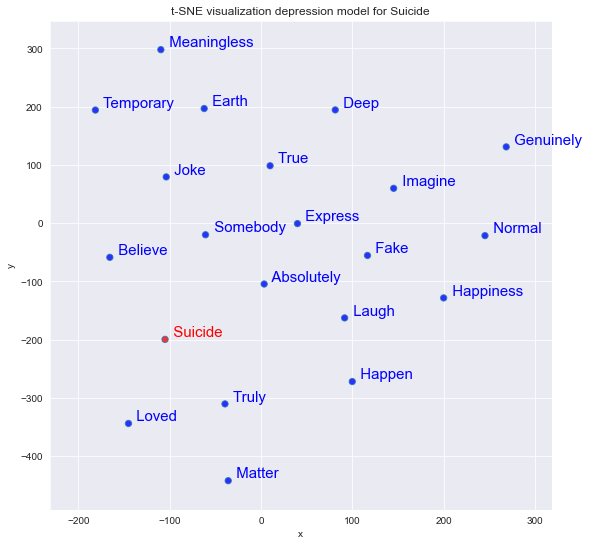

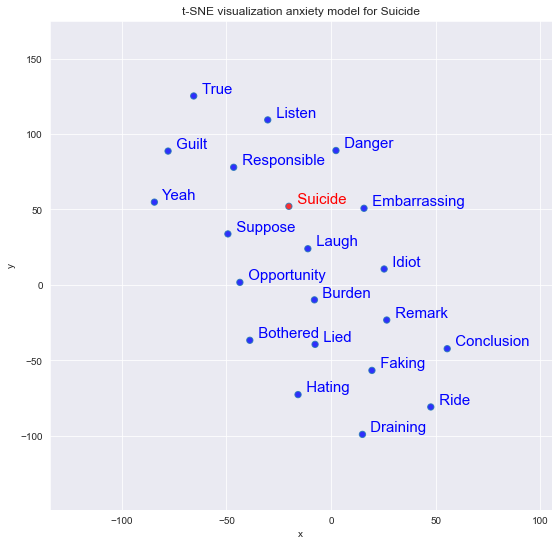

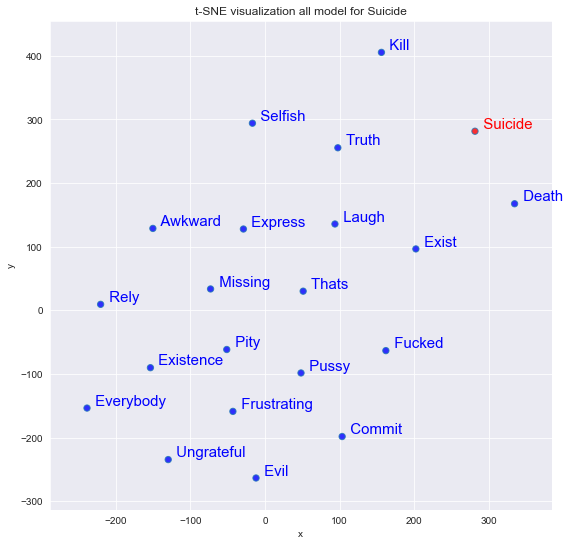

In [28]:
tsne_scatter_plot(dep_w2v_model, "depression", query, topn)
tsne_scatter_plot(anx_w2v_model, "anxiety", query, topn)
tsne_scatter_plot(all_w2v_model, "all", query, topn)

#### Cosine similarity

In [53]:
query = "suicide"
target_list = ["woman", "man", "girl", "boy"]
cosine_distance(dep_w2v_model, query, target_list, len(target_list))

[('man', 0.9016111),
 ('boy', 0.8597928),
 ('woman', 0.74844956),
 ('girl', 0.35831314)]

#### Analogy

In [ ]:
positive =['', '']     #['پدر', 'زن'] 
negative = ['']      #['مرد']
analogy(model, positive, negative, topCount=1)